# AstroDB - Wikipedia Scraping
This notebook contains capabilities to scrape data from the 'List of Space Travellers' Wikipedia page found here:
https://en.wikipedia.org/wiki/List_of_space_travelers_by_name

This a proof of concept to get from, Scraped Data --> Data Frame --> Visualisation and test new visualisations

In [2]:
from bs4 import BeautifulSoup
import urllib
from urllib.request import urlopen
import datetime
import re
import json
import pandas as pd
import numpy as np
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns

## Supporting Tranformations

These are the transformations that we want to make available.  i.e. Data we want to be available beyond the raw data we pull from Wikipedia.
The majority of these are created as the data is being scraped, but it might be better/more performant to do them as a dataframe operations.

In [3]:
#Assume all wiki formatted dates look like YYYY-mm-dd.
#This seems easier than trying to pattern match things that look like 'age'
def calculate_age(born_string):
    try:
        born = datetime.datetime.strptime(born_string, '%Y-%m-%d')
        today = datetime.date.today()
        return today.year - born.year - ((today.month, today.day) < (born.month, born.day))
    except:
        return 0

#Misson format looks like Mission 1 (Expidition 1, Expidition 2), Mission 2, Mission 3 (Expidition 1)
#Custom function to only split on commas outside of brackets
def split_mission_list(mission_list):
    missions = []
    depth = 0
    mission = ''
    for c in mission_list:
        if c == '(':
            depth += 1
        elif c == ')':
            depth -= 1
        elif not depth and c in {','}:
            missions.append(mission.strip())
            mission = ''
            continue
        mission += c
    return missions

#Possible conventions..
# x days, y hours, z minutes
# x days y hours z minutes
# xd yh zm
# xd, yh, zm
# xd, y hours and z minutes
def get_minutes_from_time_string(time_string):
    minutes_per_unit = {"m": 1, 'minutes':1, "min":1, "h": 60, "hours":60, "hrs":60, "d": 1440, "days":1440, "w": 10080,"weeks":10080}
    total_time_in_mins = 0
    for k in minutes_per_unit:
        split_time_string = time_string.split(k)
        split_time_string_trimmed = [x.strip(' ,').replace("and", "") for x in split_time_string]
        if len(split_time_string_trimmed)>1:
            last_digits_first_record = re.search(r'\d+$', split_time_string_trimmed[0])
            first_digits_last_record = re.search(r'^\d+', split_time_string_trimmed[1])
            if (last_digits_first_record and first_digits_last_record) or (last_digits_first_record and split_time_string_trimmed[1] == ''):
                total_time_in_mins += minutes_per_unit[k] * int(last_digits_first_record.group(0))
    return(total_time_in_mins)

## Data Scraping
Makes use of beautiful soup (bs4) to parse HTML from the main list of space travellers page, and each individual child page.

This has a number of specific checks for this particular page, and like most webscraping activities is very fragile to change of the source.

This code has some resilience and will attempt to retry aborted connections, but this should be improved and the code should be tidied up.

In [4]:
wiki_page="wiki/List_of_space_travelers_by_name"
site_base="https://en.wikipedia.org/{}".format(wiki_page)
hdr = {'User-Agent': 'Mozilla/5.0'}
req = urllib.request.Request(site_base,headers=hdr)
page = urlopen(req)
soup = BeautifulSoup(page.read(), "html.parser")

astro_data = []

for header in soup.find_all('h2'):
    if header.find('span',class_='mw-headline'):
        section_name = header.find('span',class_='mw-headline').get('id')
        if re.match('^[A-Z]$', section_name):
            list_of_st=header.find_next('ul')
            for st in list_of_st.find_all('li'):
                italics = st.find('i')
                if italics:
                        link = italics.find('a', class_=lambda x: x != 'image' and x != 'alt', href=True, recursive=False)
                else:
                    link = st.find('a', class_=lambda x: x != 'image', href=True, recursive=False)
                if not link or not link.text:
                    continue

                site_base="https://en.wikipedia.org{}".format(link['href'])
                            
                retries = 3
                while retries > 0 :
                    try:
                        req = urllib.request.Request(site_base,headers=hdr)
                        page = urlopen(req)
                        soup = BeautifulSoup(page.read(), "html.parser")
                    except:
                        print("error retrieving : {}".format(site_base))
                        retries = retries - 1
                        continue
                    else:
                        break

                table = soup.find('table', class_='infobox vcard')
                result = {}
                exceptional_row_count = 0
                if table:
                    for tr in table.find_all('tr'):
                       if tr.find('th') and tr.find('td') and not tr.find('th').find('span'):
                            column = tr.find('th').text.replace(" ","").replace("\n","")
                            value = tr.find('td').text
                            #Remove references from value strings
                            value = re.sub('\[[0-9]+\]','',value)
                            result['wiki_'+column] = value 
                            #handle special fields
                            if column.lower() == "born":
                                birth_date = value[value.find("(")+1:value.find(")")].strip('age')
                                age = calculate_age(birth_date)
                                result["BirthDate"] = birth_date
                                result["Age"] = age
                            if column.lower() == "missions":
                                result["MissionList"] = split_mission_list(value)
                                result["MissionList"] = [x.strip(' ') for x in result["MissionList"]]
                            if column.lower() == "timeinspace":
                                result['MinutesInSpace'] = get_minutes_from_time_string(value)
                            if column.lower() == "totalevatime":
                                result['TotalEVAMinutes'] = get_minutes_from_time_string(value)
                            #if "occupation" in column.lower():
                            #    print(value)
                astro_data.append(result)

error retrieving : https://en.wikipedia.org/wiki/James_P._Bagian
error retrieving : https://en.wikipedia.org/wiki/Eric_A._Boe
error retrieving : https://en.wikipedia.org/wiki/Duane_G._Carey
error retrieving : https://en.wikipedia.org/wiki/Laurel_B._Clark
error retrieving : https://en.wikipedia.org/wiki/Michael_Collins_(astronaut)
error retrieving : https://en.wikipedia.org/wiki/Thomas_Hennen
error retrieving : https://en.wikipedia.org/wiki/Andr%C3%A9_Kuipers
error retrieving : https://en.wikipedia.org/wiki/Andr%C3%A9_Kuipers
error retrieving : https://en.wikipedia.org/wiki/Jack_Lousma
error retrieving : https://en.wikipedia.org/wiki/Jack_Lousma
error retrieving : https://en.wikipedia.org/wiki/Yury_Malyshev_(cosmonaut)
error retrieving : https://en.wikipedia.org/wiki/William_C._McCool
error retrieving : https://en.wikipedia.org/wiki/Donald_McMonagle
error retrieving : https://en.wikipedia.org/wiki/Richard_N._Richards
error retrieving : https://en.wikipedia.org/wiki/William_Shepherd
erro

## Dataframe
Construct our dataframe from our list of dicts.  We should really pickle this up so we can use it later, scraping take a long time!

In [6]:
astro_df = pd.DataFrame(astro_data)

In [7]:
astro_df.head()

,Age,BirthDate,MinutesInSpace,MissionList,TotalEVAMinutes,wiki_Allegiance,wiki_Almamater,wiki_Awards,wiki_Battles/wars,wiki_Born,...,wiki_Timeinspace,wiki_Title(s),wiki_Total,wiki_TotalEVAs,wiki_TotalEVAtime,wiki_Unit,wiki_Website,wiki_Years,wiki_Yearsofservice,wiki_Years ofservice
0,50.0,1967-05-17,0.0,"[STS-119, Soyuz TMA-04M (Expedition 31/32)]",1186.0,United States,NaN,NaN,NaN,"Joseph Michael Acaba\n(1967-05-17) May 17, 196...",...,Currently in space,NaN,NaN,3,19 hours 46 minutes,"Marine Corps Reserve Unit in Tucson, Arizona",NaN,NaN,NaN,6 years
1,81.0,1936-03-07,11445.0,[],NaN,NaN,NaN,NaN,NaN,"(1936-03-07) March 7, 1936 (age 81)\nLewistown...",...,7d 22h 45min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,71.0,1946-03-03,20061.0,[STS-28],NaN,NaN,NaN,NaN,NaN,"(1946-03-03) March 3, 1946 (age 71)\nWarsaw, N...",...,13d 22h 21m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,68.0,1948-12-31,800313.0,"[Soyuz TM-11, Mir EO-8, Soyuz TM-18, Mir EO-15...",2284.0,NaN,NaN,,NaN,Viktor Mikhailovich Afanasyev\n(1948-12-31) 31...,...,555d 18h 33m,NaN,NaN,7,38 hours 04 minutes,NaN,NaN,NaN,NaN,NaN
4,45.0,1972-07-27,14174.0,[],NaN,NaN,NaN,NaN,NaN,(1972-07-27) 27 July 1972 (age 45)\nKazakh SSR...,...,9d 20h 14m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Visualisations

In this first example we ignore the null entries from the Age field and look at a plot of the density of the data.

Visualisations are created using the Seaborn library.

It's clear there's a lot to do here, as we've got a lot of < 1 year old astronauts!

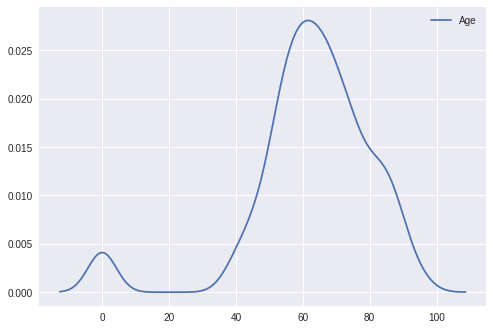

In [16]:
valid_ages = astro_df[np.isfinite(astro_df['Age'])].Age

sns.kdeplot(valid_ages)
plt.show()